In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [25]:
import sys
import os
import json
import hashlib

In [2]:
from scipy.optimize import curve_fit

In [3]:
from collections import namedtuple

In [21]:
from pymono.config import CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX
from pymono.config import BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX
from pymono.config import CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX

In [5]:
from pymono.config import test_dir

In [6]:
def bin_centers(bins):
    return np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])

In [7]:
def plotdz(xdata, ydata, figsize=(8, 6)):
    fig, ax2 = plt.subplots(1, 1, figsize=figsize)
    ax2.errorbar(xdata, ydata,yerr=np.sqrt(ydata), fmt='o', markersize=2) 
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    fig.tight_layout()
    plt.show()

In [8]:
def plotfz(xdata, ydata, yfit, norms=None, mus=None, sigmas=None, figsize=(8, 6)):
    if isinstance(norms, tuple):
        n1 = norms[0]/(norms[0]+ norms[1])
        n2 = norms[1]/(norms[0]+ norms[1])
    fig, ax2 = plt.subplots(1, 1, figsize=figsize)
    ax2.errorbar(xdata, ydata,yerr=np.sqrt(ydata), fmt='o', markersize=2)
    if sigmas == None:
        ax2.plot(xdata, yfit, 'red', linewidth=1.0)
    elif isinstance(sigmas, float):
        ax2.plot(xdata, yfit, 'red', linewidth=1.0, 
                label=f"$\sigma$ = {sigmas:.2f}")
        ax2.legend()
    elif isinstance(sigmas, tuple) and norms == None:
        ax2.plot(xdata, yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$ = {sigmas[0]:.2f}\n $\sigma_2$ = {sigmas[1]:.2f}")
        ax2.legend()
    elif isinstance(sigmas, tuple) and isinstance(norms, tuple):
        ax2.plot(xdata, yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {sigmas[1]:.2f}")
        ax2.legend()
        
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    fig.tight_layout()
    plt.show()

In [48]:
def plotfxyz(f2gx, f2gy, f2gz, figsize=(8, 6)):
    def n1n2(norms):
        n1 = norms[0]/(norms[0]+ norms[1])
        n2 = norms[1]/(norms[0]+ norms[1])
        return n1, n2
        
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    flat_axes = axes.ravel()
    ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

    n1, n2 = n1n2(f2gx.norms)
    ax0.errorbar(f2gx.xdata, f2gx.ydata,yerr=np.sqrt(f2gx.ydata), fmt='o', markersize=2)
    ax0.plot(f2gx.xdata, f2gx.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gx.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gx.sigmas[1]:.2f}")
    ax0.legend()
    ax0.set_xlabel("NN (xtrue - xpredicted)",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    
    n1, n2 = n1n2(f2gy.norms)
    ax1.errorbar(f2gy.xdata, f2gy.ydata,yerr=np.sqrt(f2gy.ydata), fmt='o', markersize=2)
    ax1.plot(f2gy.xdata, f2gy.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gy.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gy.sigmas[1]:.2f}")
    ax1.legend()
    ax1.set_xlabel("NN (ytrue - ypredicted)",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)

    n1, n2 = n1n2(f2gz.norms)
    ax2.errorbar(f2gz.xdata, f2gz.ydata,yerr=np.sqrt(f2gz.ydata), fmt='o', markersize=2)
    ax2.plot(f2gz.xdata, f2gz.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gz.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gz.sigmas[1]:.2f}")
    ax2.legend()
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)

    fig.tight_layout()
    plt.show()

In [9]:
def fit_sgaussian(xdata, ydata, pars=[10000., 0.5, 2.0]):
    def gaussian(x, a1, mu1, sigma1):
        return a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
        
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars)
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 
 

In [11]:
def fit_dgaussian(xdata, 
                  ydata, 
                  pars=[10000., 0.5, 2.0, 10000., 0.5, 2.0],
                  lower_bounds = [0, -1.0, 0.0, 0.0, -1.0, 0.0],
                  upper_bounds = [100000, 1.0, 15.0, 100000.0, 1.0, 15.0]
                 ):

    def gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
        g1 = a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
        g2 = a2*(np.exp(-(x-mu2)**2/(2*sigma2**2)))
        return g1 + g2
    
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars, 
                          bounds=(lower_bounds, upper_bounds))
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 


In [12]:
def get_data(file="delta_z_NN.npy", bins=100):
    dz =np.load(file)
    hdz, binsz = np.histogram(dz, bins=bins)
    xdata = bin_centers(binsz)
    ydata = hdz
    return xdata, ydata


In [45]:
def fitcoord(file="delta_z_NN.npy", bins=100):
    xdata, ydata = get_data(file, bins)
    pars, err, yfit = fit_dgaussian(xdata, ydata)
    n1 = pars[0]/(pars[0]+ pars[3])
    n2 = pars[3]/(pars[0]+ pars[3])
    we = weighted_error(pars[2], n1, pars[5], n2)
    print(f"2g fit: mu1 = {pars[1]:.2f}, sigma = {pars[2]:.2f}, n1  ={n1:.2f}")
    print(f"2g fit: mu2 = {pars[4]:.2f}, sigma = {pars[5]:.2f}, n1  ={n2:.2f}")
    print(f"weighted error: = {we:.2f}")
   
    plotfz(xdata, ydata, yfit, 
       norms=(pars[0], pars[3]),
       mus=(pars[1], pars[4]), 
       sigmas=(pars[2], pars[5]),
       figsize=(6, 4))

In [14]:
def weighted_error(sigma1, w1, sigma2, w2):
    return sigma1 * w1 + sigma2 * w2

In [44]:
def fitcoord2g(file="delta_z_NN.npy", bins=100):
    xdata, ydata = get_data(file, bins)
    pars, err, yfit = fit_dgaussian(xdata, ydata)
    n1 = pars[0]/(pars[0]+ pars[3])
    n2 = pars[3]/(pars[0]+ pars[3])
    we = weighted_error(pars[2], n1, pars[5], n2)
    print(f"2g fit: mu1 = {pars[1]:.2f}, sigma = {pars[2]:.2f}, n1  ={n1:.2f}")
    print(f"2g fit: mu2 = {pars[4]:.2f}, sigma = {pars[5]:.2f}, n1  ={n2:.2f}")
    print(f"weighted error: = {we:.2f}")

    fit2g = namedtuple('fit2g',
           'xdata, ydata, yfit, norms, mus, sigmas')
    return fit2g(xdata, ydata, yfit, 
                (pars[0], pars[3]), (pars[1], pars[4]), (pars[2], pars[5]))
    

In [17]:
def fit_coord(files=("delta_z_NN.npy", 
                     "delta_x_NN.npy", 
                     "delta_y_NN.npy"), bins=100):
    
    f2gz = fitcoord2g(file=files[0], bins=bins)
    f2gx = fitcoord2g(file=files[1], bins=bins)
    f2gy = fitcoord2g(file=files[2], bins=bins)
    
    return f2gz, f2gx, f2gy

In [27]:
def get_hash(config):
    json_string = json.dumps(config)
    print(f" cnn_watch: Watch configuration ->{json_string}")
    encoded_string = json_string.encode()
    hash_object_md5 = hashlib.md5(encoded_string)
    hex_hash_md5 = hash_object_md5.hexdigest()
    return hex_hash_md5

In [22]:
means_par ={CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX:165.90,
            CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX:31.96,
            BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX:18.60}
stds_par={CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX:93.3,
          CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX:46.79,
            BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_NX:5.0}
   

In [24]:
config_CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX={  
          "project" :"cnn-mon",
          "dataset": CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX,
          "epochs": 20,
          "dropout": True,
          "dropout_fraction":0.3,
          "architecture": "CNN3x3",   # or "architecture": "CNN3x3"
          "optimizer": "Adam",
          "criterion": "MSELos",
          "learning_rate": 0.001,
          "first_file": 0,  # initial file indx
          "last_file": 100,  # lasta file indx
          "norm": True, 
          "mean": means_par[CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX], #
          "std": stds_par[CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX],
          "batch_size": 1000,
          "train_fraction" : 0.7, 
          "val_fraction": 0.2,
      }

print(f"Configuration ->", config_CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX)

Configuration -> {'project': 'cnn-mon', 'dataset': '/Users/jjgomezcadenas/data/monolith/CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX', 'epochs': 20, 'dropout': True, 'dropout_fraction': 0.3, 'architecture': 'CNN3x3', 'optimizer': 'Adam', 'criterion': 'MSELos', 'learning_rate': 0.001, 'first_file': 0, 'last_file': 100, 'norm': True, 'mean': 31.96, 'std': 46.79, 'batch_size': 1000, 'train_fraction': 0.7, 'val_fraction': 0.2}


In [35]:
def getxyz(config):
    hex_hash_md5 = get_hash(config)
    idir = os.path.join(test_dir, hex_hash_md5)
    dxnn = os.path.join(idir, "delta_x_NN.npy")
    dynn = os.path.join(idir, "delta_y_NN.npy")
    dznn = os.path.join(idir, "delta_z_NN.npy")
    return dznn, dxnn, dynn

In [36]:
dznn, dxnn, dynn = getxyz(config_CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX)

 cnn_watch: Watch configuration ->{"project": "cnn-mon", "dataset": "/Users/jjgomezcadenas/data/monolith/CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX", "epochs": 20, "dropout": true, "dropout_fraction": 0.3, "architecture": "CNN3x3", "optimizer": "Adam", "criterion": "MSELos", "learning_rate": 0.001, "first_file": 0, "last_file": 100, "norm": true, "mean": 31.96, "std": 46.79, "batch_size": 1000, "train_fraction": 0.7, "val_fraction": 0.2}


In [54]:
f2gz, f2gx, f2gy = fit_coord(files=(dznn, dxnn, dynn), bins=100)

2g fit: mu1 = 0.01, sigma = 0.37, n1  =0.53
2g fit: mu2 = -0.10, sigma = 0.73, n1  =0.47
weighted error: = 0.54
2g fit: mu1 = 0.27, sigma = 1.57, n1  =0.24
2g fit: mu2 = 0.24, sigma = 0.45, n1  =0.76
weighted error: = 0.72
2g fit: mu1 = 0.00, sigma = 0.43, n1  =0.67
2g fit: mu2 = -0.09, sigma = 1.37, n1  =0.33
weighted error: = 0.74


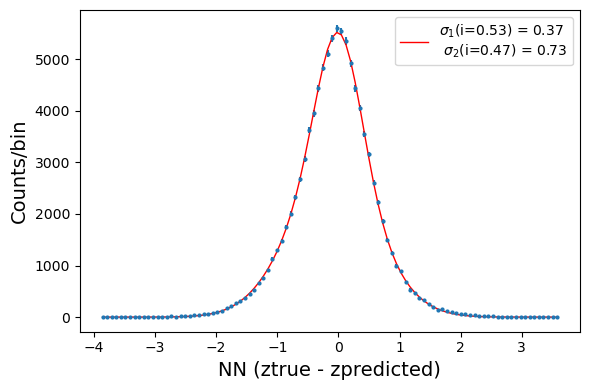

In [42]:
plotfz(*f2gz, figsize=(6, 4))

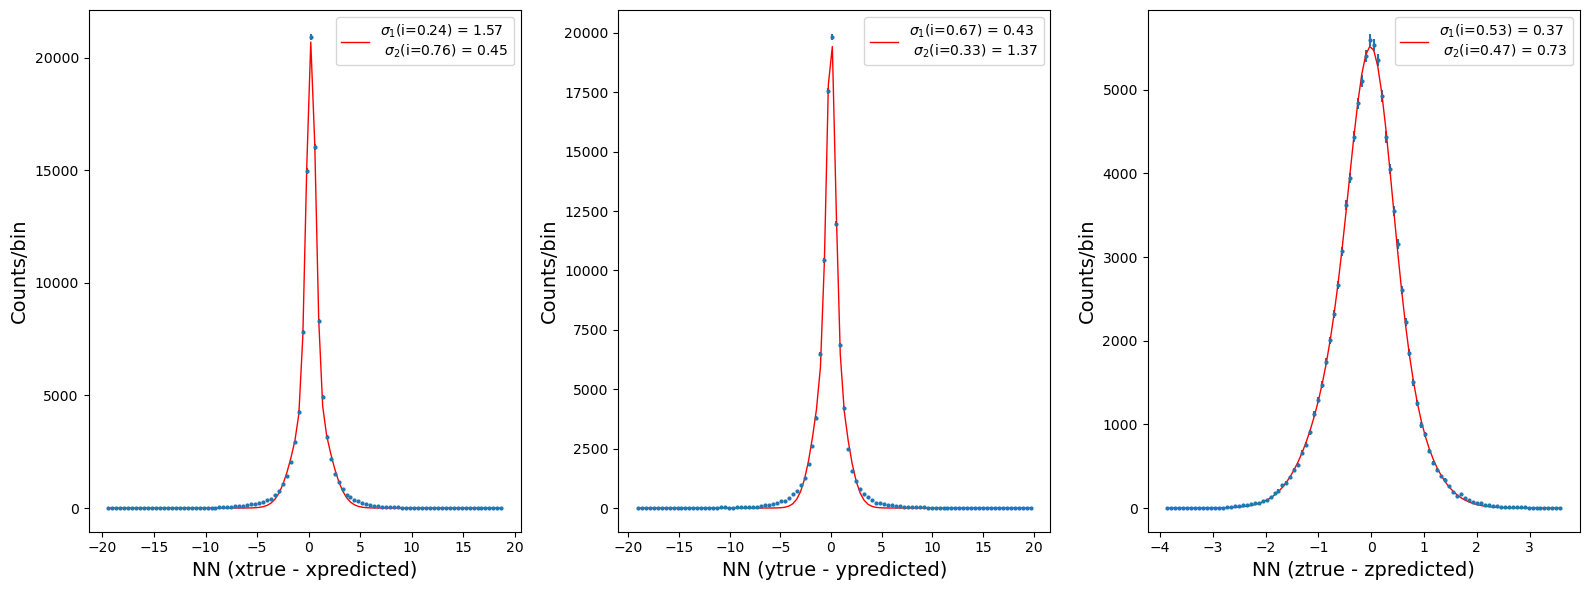

In [53]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(16, 6))